# Bibliotecas

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [13]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})    

# Carregando os dados iniciais

In [14]:
df = pd.read_csv("solicitacoescredito.csv")
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.0,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,...,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.0,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8973 entries, 0 to 8972
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           8973 non-null   int64  
 1   razaoSocial                  8973 non-null   object 
 2   nomeFantasia                 8973 non-null   object 
 3   cnpjSemTraco                 8973 non-null   object 
 4   maiorAtraso                  8973 non-null   int64  
 5   margemBrutaAcumulada         8973 non-null   float64
 6   percentualProtestos          7475 non-null   float64
 7   primeiraCompra               8867 non-null   object 
 8   prazoMedioRecebimentoVendas  8973 non-null   int64  
 9   titulosEmAberto              8973 non-null   float64
 10  valorSolicitado              8973 non-null   float64
 11  status                       8973 non-null   object 
 12  definicaoRisco               8973 non-null   object 
 13  diferencaPercentua

In [16]:
df_temporal = df[['dataAprovadoNivelAnalista', 'dataAprovadoEmComite', 'valorAprovado']]
df_temporal['dataAprovadoEmComite'].fillna(df_temporal['dataAprovadoNivelAnalista'], inplace=True)
df_temporal.drop('dataAprovadoNivelAnalista', axis=1, inplace=True)
df_temporal.rename({'dataAprovadoEmComite': 'data'}, axis=1, inplace=True)
df_temporal.dropna(inplace=True)
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7569 entries, 0 to 8961
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   data           7569 non-null   object 
 1   valorAprovado  7569 non-null   float64
dtypes: float64(1), object(1)
memory usage: 177.4+ KB


In [17]:
df_temporal.data[0][:-9]
df_temporal.data = [x[:-9] for x in df_temporal.data]
df_temporal.valorAprovado = df_temporal.valorAprovado.astype('int64')
df_temporal

,data,valorAprovado
0,2020-02-03,50000
2,2020-02-04,20000
3,2020-02-04,15000
4,2020-02-04,50000
5,2020-02-04,20000
...,...,...
8956,2021-02-25,45000
8957,2021-02-25,15000
8958,2021-02-25,1500000
8960,2021-02-25,20000


In [19]:
df_temporal_agrupado = df_temporal.groupby('data', as_index=False).sum()
df_temporal_agrupado.sort_values('data', inplace=True)
df_temporal_agrupado

,data,valorAprovado
0,2020-02-03,50000
1,2020-02-04,1243000
2,2020-02-05,2952000
3,2020-02-06,5545000
4,2020-02-07,4685000
...,...,...
259,2021-02-19,7911900
260,2021-02-22,4272000
261,2021-02-23,13826500
262,2021-02-24,7255000


In [ ]:
df_base_dias = pd.date_range(start='2020-02-03', end='2021-02-25')
df_base_dias = df_base_dias.format(formatter=lambda x: x.strftime('%Y-%m-%d'))
df_base_dias = pd.DataFrame(df_base_dias, columns=['data'])
df_base_dias

In [20]:
#df_temporal = pd.merge(df_base_dias, df_temporal_agrupado, how='left')
df_temporal = df_temporal_agrupado
df_temporal.data = df_temporal.index + 1
df_temporal.rename({'data': 'dia', 'valorAprovado': 'valor'}, axis=1, inplace=True)
df_temporal

,dia,valor
0,1,50000
1,2,1243000
2,3,2952000
3,4,5545000
4,5,4685000
...,...,...
259,260,7911900
260,261,4272000
261,262,13826500
262,263,7255000


In [21]:
df_temporal.isnull().sum()

dia      0
valor    0
dtype: int64

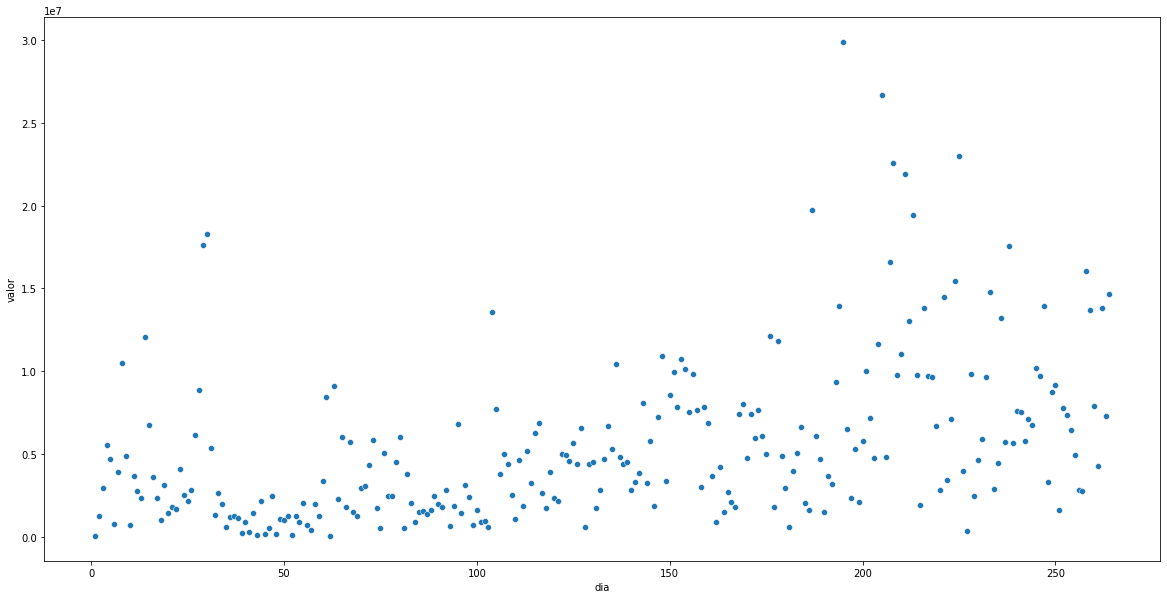

In [22]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(x=df_temporal.dia, y=df_temporal.valor)
plt.show()

In [ ]:
imputer = KNNImputer(n_neighbors=2)
knn = imputer.fit_transform(df_temporal)
knn = knn.astype('int64')
knn

In [ ]:
df_dias = pd.DataFrame(knn[:,1], columns=['valor'])
df_dias.head(20)

In [ ]:
fig = plt.figure(figsize=(20,8))
sns.scatterplot(x=df_dias.index, y=df_dias.valor)
plt.title('Valor aprovado por dia', size=24)
plt.show()

In [ ]:
sns.histplot(df_dias)

In [ ]:
df_dias.describe()

# Modelo ARIMA

# Previsão por Dia

In [ ]:
df_arima = df_dias.copy()

result = adfuller(df_arima)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(20,16))
axes[0, 0].plot(df_arima.valor)
axes[0, 0].set_title('Original Series')
plot_acf(df_arima.valor, ax=axes[0, 1], lags=388)

# 1st Differencing
axes[1, 0].plot(df_arima.valor.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_arima.valor.diff().dropna(), ax=axes[1, 1], lags=387)

# 2nd Differencing
axes[2, 0].plot(df_arima.valor.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_arima.valor.diff().diff().dropna(), ax=axes[2, 1], lags=386)

plt.show()


In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_arima.valor.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_arima.valor.diff().dropna(), ax=axes[1], lags=190)

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_arima.valor.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_arima.valor.diff().dropna(), ax=axes[1], lags=387)

plt.show()

In [ ]:
model = ARIMA(df_arima.valor, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], legend=False)
residuals.plot(kind='kde', title='Density', ax=ax[1], legend=False)
plt.show()

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.title('Previsão x Original')
plt.show()

In [ ]:
# Create Training and Test
train_arima = df_arima.valor[:374]
test_arima = df_arima.valor[374:]

In [ ]:
model = ARIMA(df_arima.valor, order=(1,1,1))
model_fit = model.fit(disp=1)

# Forecast
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_arima.index)
lower_series = pd.Series(conf[:, 0], index=test_arima.index)
upper_series = pd.Series(conf[:, 1], index=test_arima.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_arima, label='training')
plt.plot(test_arima, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='r', alpha=.15)
plt.title('Previsão x Original')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mean_absolute_percentage_error(fc_series, test_arima)

# Previsão por Dias

In [23]:
X = np.array(df_temporal.valor)
X = X.astype('float32').reshape(-1,1)

In [24]:
X.shape

(264, 1)

In [25]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

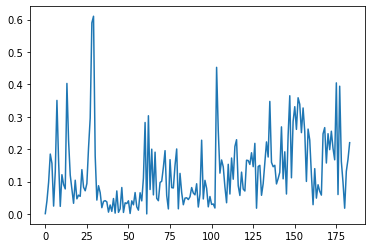

In [27]:
plt.plot(train)

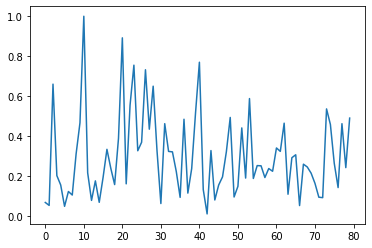

In [28]:
plt.plot(test)

In [31]:
best = 0
best_mse = np.Infinity
for n in range(51, 61, 1):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 51 - 0.021117042750120163 | best 51 - 0.021117042750120163
look back 52 - 0.019790098071098328 | best 52 - 0.019790098071098328
look back 53 - 0.019168533384799957 | best 53 - 0.019168533384799957
look back 54 - 0.016666855663061142 | best 54 - 0.016666855663061142
look back 55 - 0.017085256054997444 | best 54 - 0.016666855663061142
look back 56 - 0.01744994893670082 | best 54 - 0.016666855663061142
look back 57 - 0.018329225480556488 | best 54 - 0.016666855663061142
look back 58 - 0.018640335649251938 | best 54 - 0.016666855663061142
look back 59 - 0.019427794963121414 | best 54 - 0.016666855663061142
look back 60 - 0.021187881007790565 | best 54 - 0.016666855663061142


In [ ]:
train

In [32]:
# quantidade de atrasos
look_back = 54

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)


In [33]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
X_train.shape

(129, 54, 1)

In [35]:
y_train.shape

(129,)

# Modelo LSTM

In [36]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [37]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [38]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

Epoch 1/100
127/129 [============================>.] - ETA: 0s - loss: 0.0099
Epoch 00001: val_loss improved from inf to 0.02004, saving model to .\modelo_lstm_ex4.hdf5
129/129 [==============================] - 1s 7ms/step - loss: 0.0098 - val_loss: 0.0200
Epoch 2/100
128/129 [============================>.] - ETA: 0s - loss: 0.0097
Epoch 00002: val_loss did not improve from 0.02004
129/129 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0257
Epoch 3/100
111/129 [========================>.....] - ETA: 0s - loss: 0.0100
Epoch 00003: val_loss did not improve from 0.02004
129/129 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0225
Epoch 4/100
123/129 [===========================>..] - ETA: 0s - loss: 0.0086
Epoch 00004: val_loss did not improve from 0.02004
129/129 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0237
Epoch 5/100
117/129 [==========================>...] - ETA: 0s - loss: 0.0097
Epoch 0000

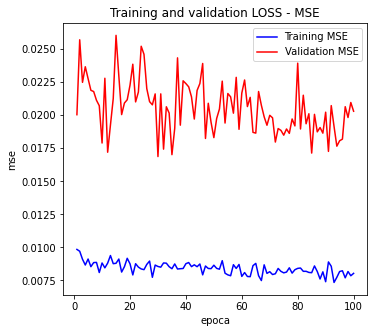

In [39]:
plot_history(history)

In [40]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [41]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [42]:
trainPredict.shape

(129, 1)

In [43]:
y_train.shape

(129,)

In [44]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [45]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2973243.20 RMSE
Test Score: 3879864.40 RMSE


In [46]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [47]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

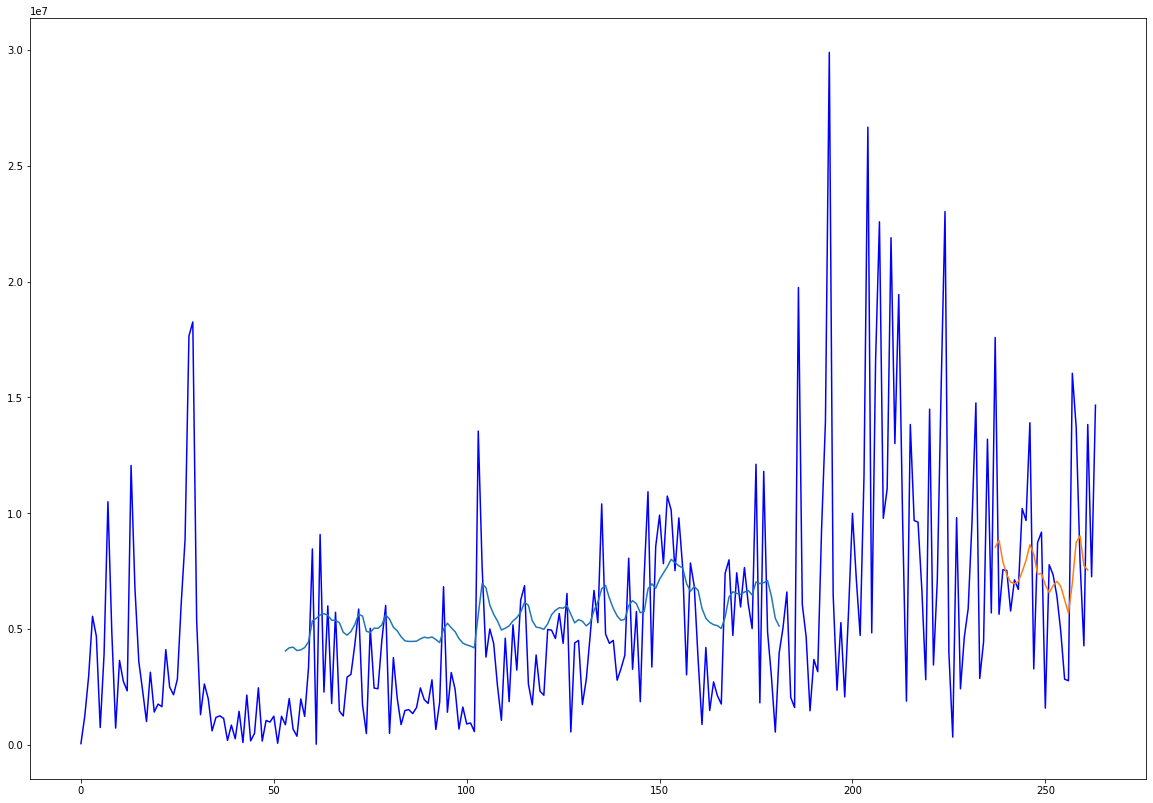

In [48]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
y_te = y_te.reshape(-1,1)

In [ ]:
mean_absolute_percentage_error(testPredict, y_te)

# Modelo GRU

In [ ]:
model = Sequential()
model.add(GRU(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
checkpointer = ModelCheckpoint(filepath='./modelo_gru_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, callbacks=[checkpointer])

In [ ]:
plot_history(history)

In [ ]:
model = load_model("./modelo_gru_ex4.hdf5")

In [ ]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [ ]:
trainPredict.shape

In [ ]:
y_train.shape

In [ ]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [ ]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [ ]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

In [ ]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()